## Prevendo valores de ações com algoritmos de machine learning e deep learning 🎯

O objetivo desta aula é realizarmos 4 tipos de testes de predição de séries temporais!

Vamos utilizar desde modelos mais tradicionais como a **média móvel** e o **ARIMA**, até modelos mais robusto como o **prophet** do Facebook (Meta) e ainda a deep learning **LSTM**. Vamos lá?

## Sobre o dataset 🎲

O dataset é composto pelo histórico do valor das ações da **Disney** no período de *01/01/2018 até 11/12/2023*.

Link para acessar dados do Yahoo Finanças:

https://br.financas.yahoo.com/quote/MSFT/history?period1=1420070400&period2=1652918400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true


### Importando as bibliotecas necessárias:

In [33]:
#!pip uninstall -y fbprophet
#!pip uninstall -y pystan
#!pip install fbprophet
#!pip install pystan==2.19.1.1

In [34]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf


#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

### Upload do dataframe:

In [35]:
import yfinance as yf

# Especifique o símbolo da Bolsa ('^BVSP') e o intervalo de datas desejado
symbol = '^BVSP'
start_date = '2023-01-22'
end_date = '2024-01-22'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [36]:
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-23,112041.0,113061.0,111542.0,111709.0,111709.0,13701000
1,2023-01-24,111746.0,113040.0,111669.0,113028.0,113028.0,11551500
2,2023-01-25,113028.0,114386.0,111927.0,114195.0,114195.0,11413000
3,2023-01-26,114271.0,114835.0,113591.0,114109.0,114109.0,10920800
4,2023-01-27,114178.0,114191.0,112044.0,112502.0,112502.0,10614500


In [37]:
df.shape #analisando linhas e colunas

(247, 7)

In [38]:
df_Bolsa = df # criando cópia do dataset

### Visualizando os valores de fechamento

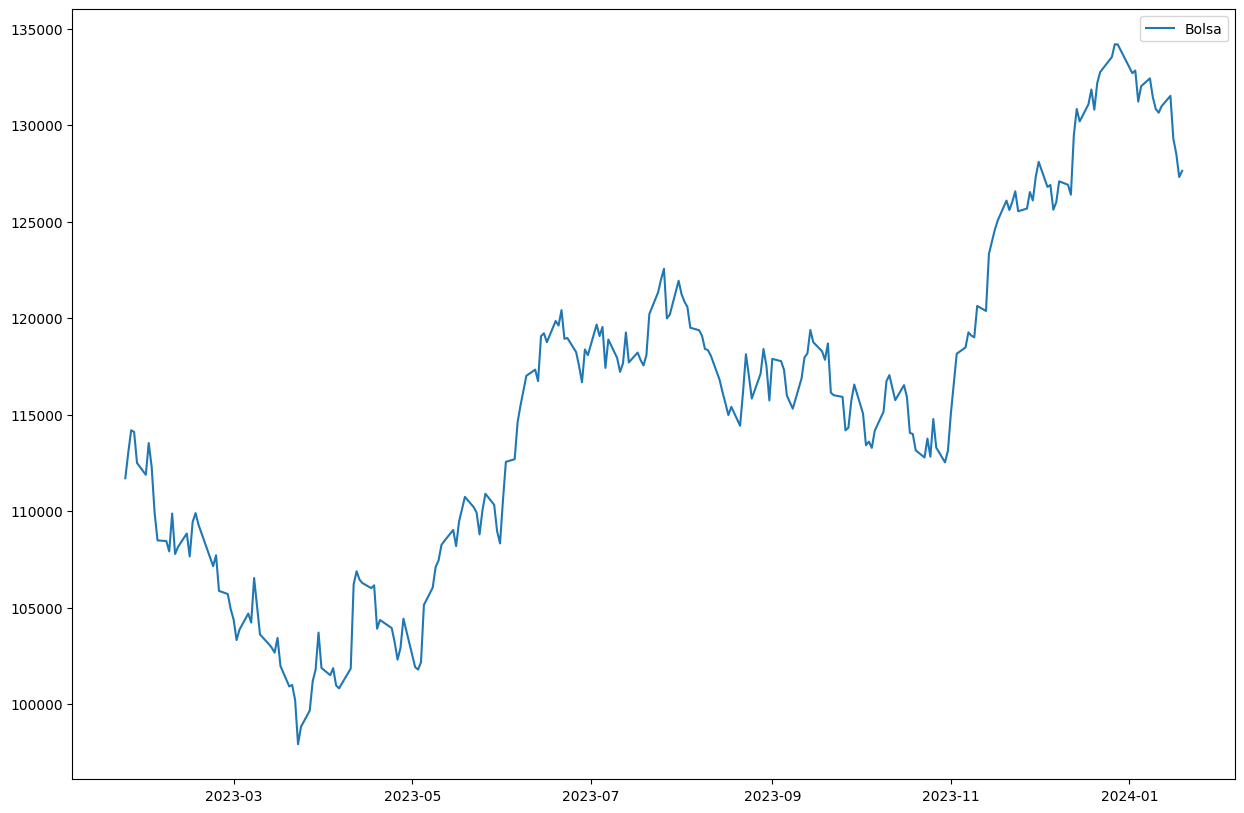

In [39]:
plt.figure(figsize = (15,10))
plt.plot(df['Date'], df['Adj Close'], label='Bolsa')

plt.legend(loc='best')
plt.show()

# Análise de série temporal (Decomposição) 📈

Dentro das etapas de análise de uma série temporal, existe a etapa da realização de sua decomposição. Decompor uma série temporal significa você analisar:

- Tendencia
- Sazonalidade
- Ruído

Iremos utilizar o Statsmodel para decompor nossos dados e visualizar vários gráficos. Utilizar a decomposição dos dados da série pode **auxiliar na compreensão dos dados e na tomada de decisão de qual modelo preditivo utilizar**.

Ao compreender a tendência, podemos fazer previsões de longo prazo.

Ao entender a sazonalidade, podemos prever padrões de curto prazo.

E ao analisar os resíduos, podemos entender o que não foi capturado pelos dois primeiros componentes e, assim, melhorar nossos modelos. 😊

## O que é tendência?
**Direcionamento** de sua série temporal (para qual direção ela está indo).

## O que é Sazonalidade?
Encontrar **caracteristicas e padrões no tempo** que podem aparecer de forma repetida.

## O que é o ruído?
Após extrair a tendência e a sazonalidade da série original, o que resta é chamado de resíduo. Os resíduos são a **diferença entre a série original e o que foi explicado pela tendência e sazonalidade**.

## Série aditiva ou multiplicativa

A decomposição pode ajudar a identificar se uma série temporal é **aditiva ou multiplicativa**. Uma série é considerada **aditiva** quando a **magnitude da sazonalidade e da tendência não varia com o tempo**. Por outro lado, em uma série **multiplicativa**, a **magnitude da sazonalidade ou da tendência varia em proporção ao nível da série.**



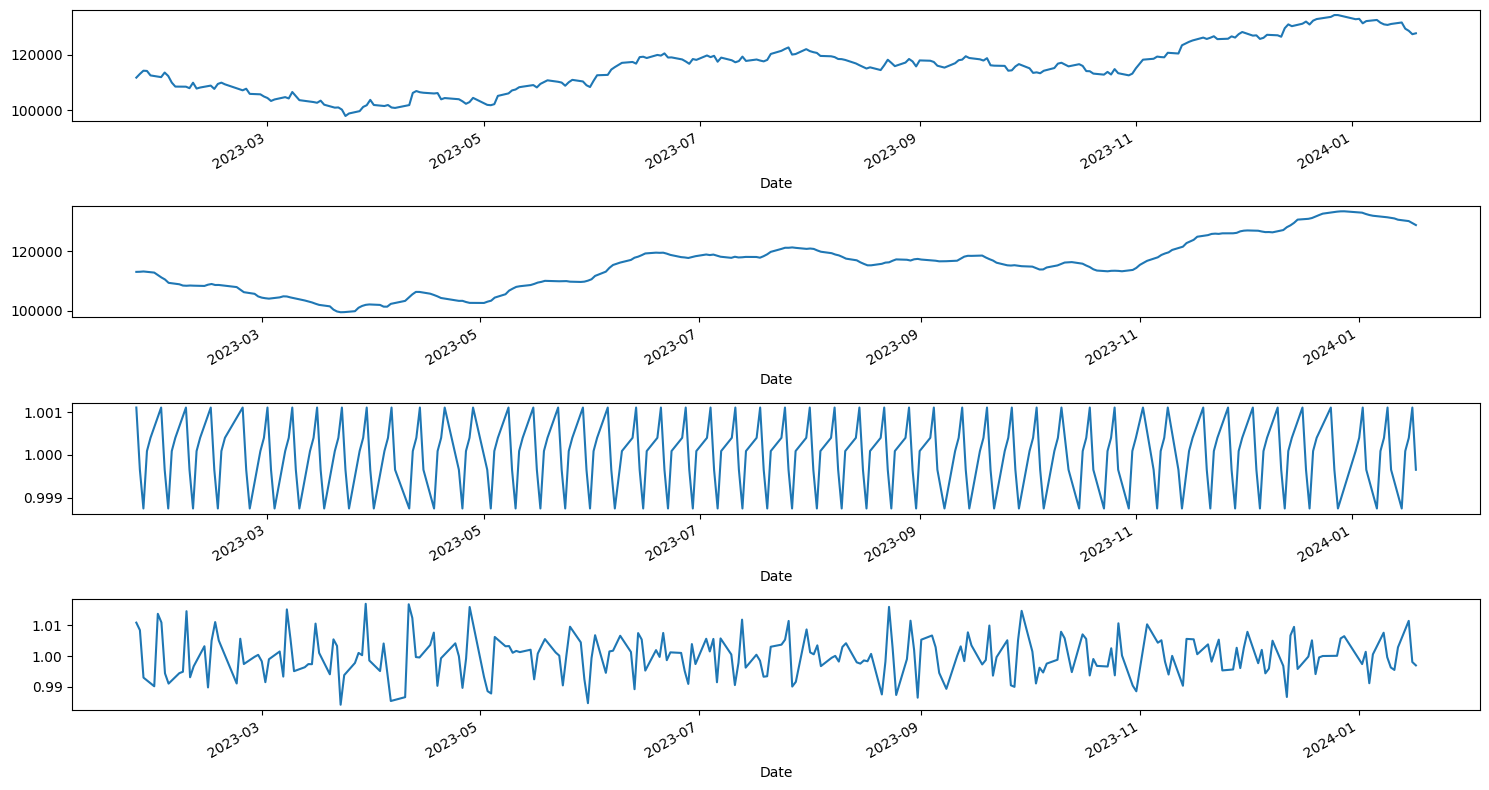

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_limpo = df                                                              # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])                        # transformando em datetime
df_limpo = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']) # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')                                      # definindo data como índice

################################## Notas da análise de decomposição da série ########################################

# model='additive': Este parâmetro especifica o tipo de modelo utilizado na decomposição.

# Os dois tipos principais são:

# "additive" (modelo apropriado quando a magnitude da sazonalidade não varia com a tendência)
# "multiplicative" (modelo é mais apropriado quando a magnitude da sazonalidade varia com a tendência).

# period: Este é o período da sazonalidade. Ele especifica o número de observações em um ciclo sazonal.

######################################################################################################################

seasonplot = seasonal_decompose(df_limpo, model='multiplicative', period=5) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

## E por que as ações estão caindo? 🏰✨

**Uma das possíveis causas:** Pandemia do covid trouxe grandes impcatos que a disney está enfrentando até os dias de hoje (em 2023).

**Recomendação de vídeo:** https://youtu.be/v7ybYLS9tTo?si=mSIneB3BLd-YbEn9


✨**Dica:** Na análise exploratória, não vale apenas olhar para os dados, mas também entender o que aconteceu com o mundo, a economia e todos os fatores externos que podem ter impactado as variações da série temporal.

## Testando modelos clássicos: Média Móvel 📈⏳

Um algoritmo clássico para este tipo de problema é o da Média Móvel. Ele consiste em utilizar a **média de N dias observados para prever o próximo dia**. Vamos utilizar esta técnica para um N de 10 e de 20 dias.


In [41]:
#Filtrando os dados
df = pd.DataFrame(df[['Adj Close','Date']])
df.set_index('Date', inplace=True)

In [42]:
df['MA_window_10'] = df['Adj Close'].rolling(10).mean().shift() #média móvel em 10 dias
df['MA_window_20'] = df['Adj Close'].rolling(20).mean().shift() #média móvel em 20 dias

#Rolling para deslocamento. Este parâmetro especifica o número de observações usadas para calcular a estatística
#shift é utilizado para deslocar o índice de DataFrame por um número especificado de períodos com uma freqüência de tempo opcional

In [43]:
df.head(20)

,Adj Close,MA_window_10,MA_window_20
Date,,,
2023-01-23,111709.0,NaN,NaN
2023-01-24,113028.0,NaN,NaN
2023-01-25,114195.0,NaN,NaN
2023-01-26,114109.0,NaN,NaN
2023-01-27,112502.0,NaN,NaN
2023-01-30,111888.0,NaN,NaN
2023-01-31,113532.0,NaN,NaN
2023-02-01,112303.0,NaN,NaN
2023-02-02,109935.0,NaN,NaN


### Visualizando o resultado:

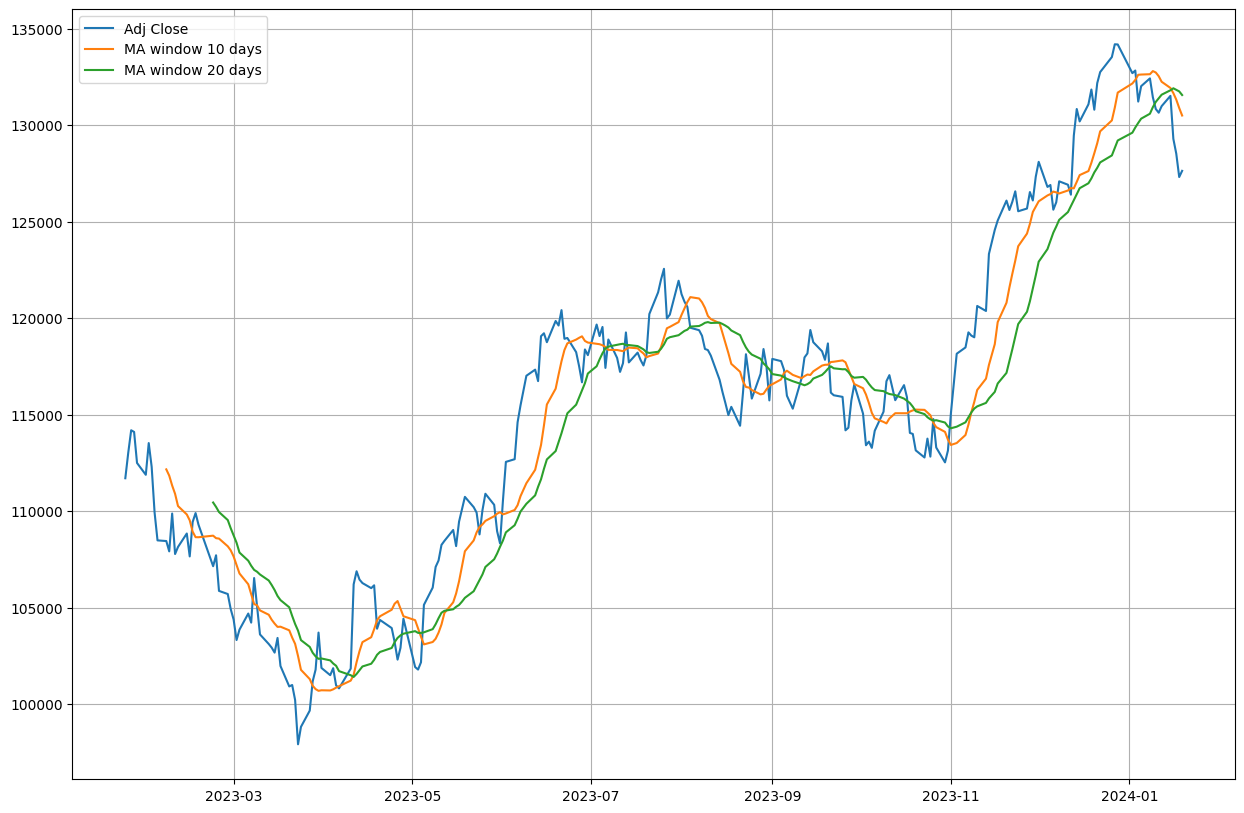

In [44]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Adj Close'], label='Adj Close')
plt.plot(df['MA_window_10'], label='MA window 10 days')
plt.plot(df['MA_window_20'], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

### Visualizando os dados mais recentes: últimos 300 dias

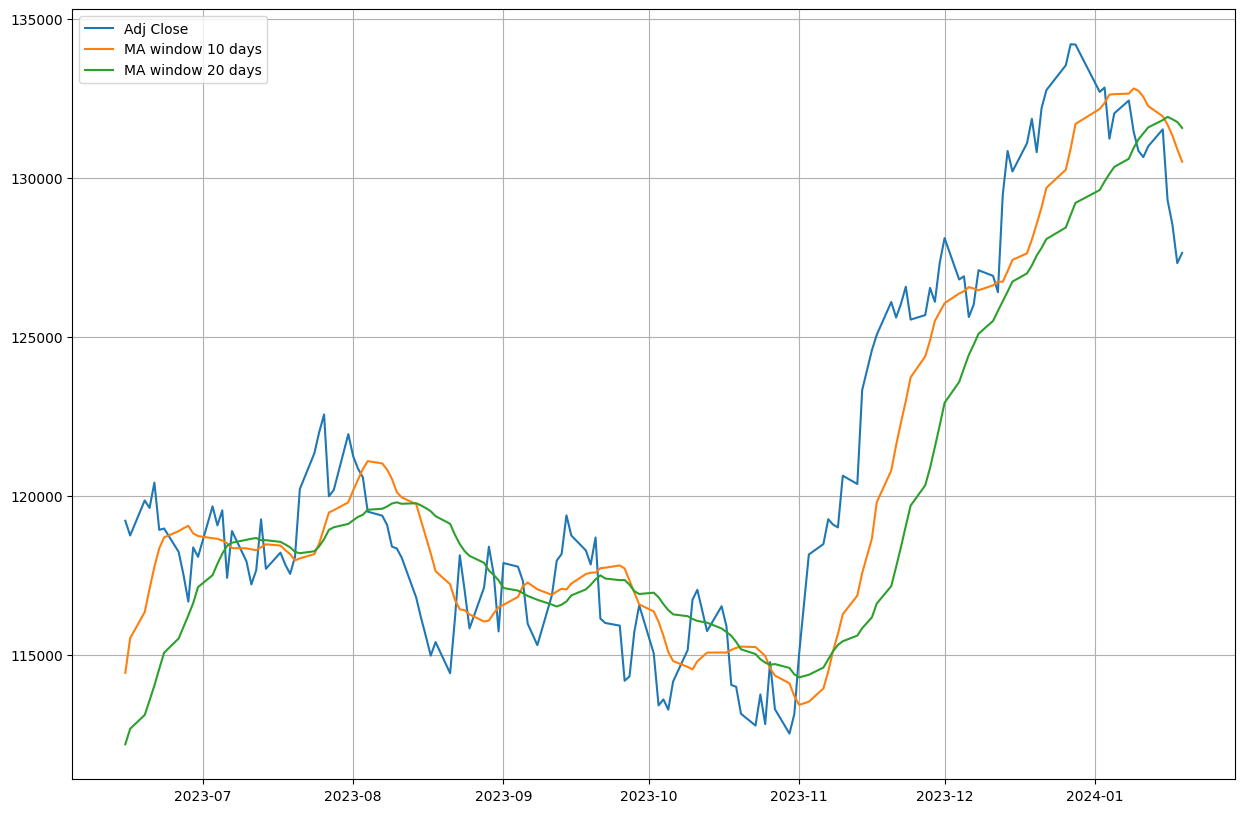

In [45]:
limit = 150

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Adj Close'][-limit:], label='Adj Close')
plt.plot(df['MA_window_10'][-limit:], label='MA window 10 days')
plt.plot(df['MA_window_20'][-limit:], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

### Prevendo os "N" dias com base na média móvel aritmética

In [46]:
df['MA_window_10_forward_10'] = np.NaN #preechendo com NaN os valores da coluna de MA_window_10_forward_10

In [47]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]  #realizando a janela de tempo

In [48]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Adj Close'].iloc[window_close], df['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_10_forward_10')] = mean


Plotando os dados:

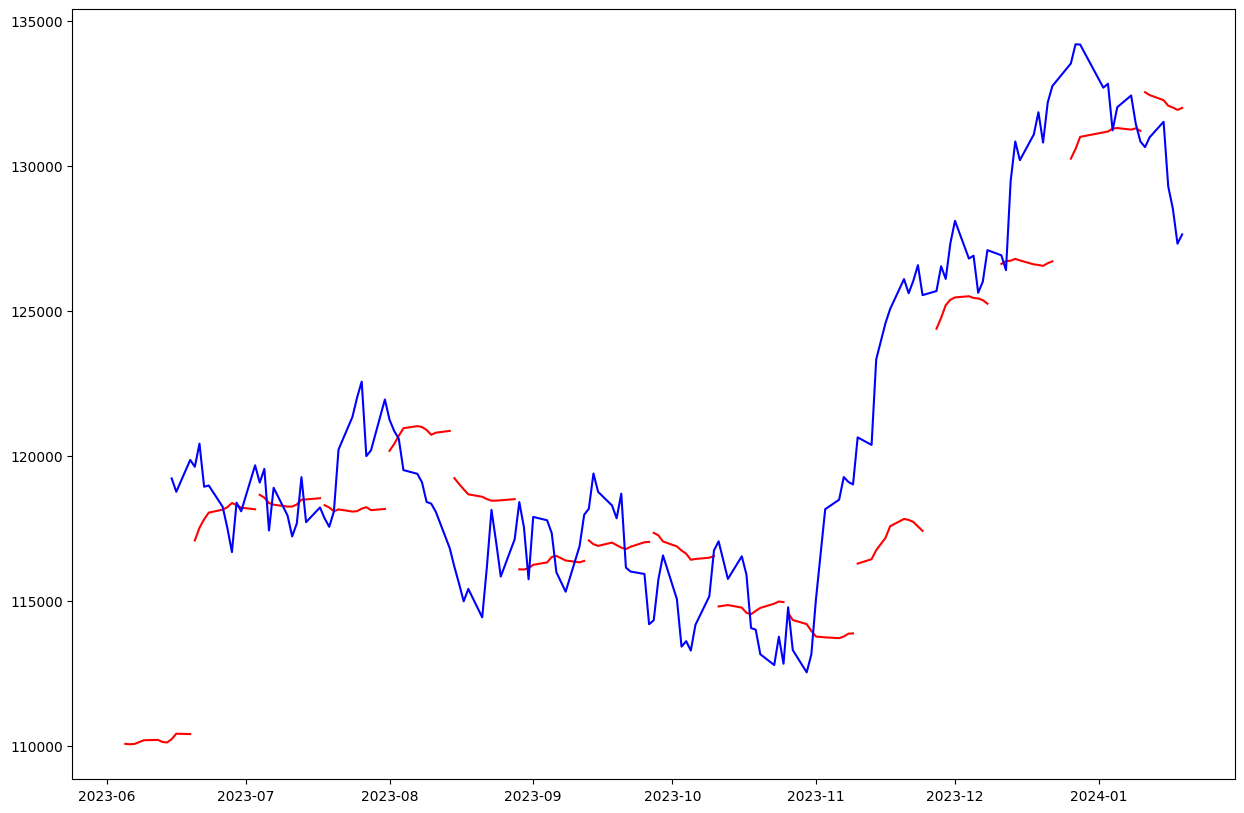

In [49]:
plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df['Adj Close'][-limit:], color='b', label='Adj Close')
#plt.legend(loc='best')
plt.show()

Note que cada reta vermelha no gráfico representa uma previsão de 10 dias, baseado nos 10 dias anteriores. Por isso elas são descontínuas.

Este tipo de abordagem é muito simplista. Isto porque o verdadeiro objetivo é prever N dias a frente para ver qual será o comportamento da ação. E ambos algoritmos falham nessa função. Vamos testar mais um clássico? Vamos analisar como o ARIMA funciona.

## Testando o modelo ARIMA 💹

ARIMA significa **Média Móvel Integrada Auto-Regressiva**.

Um modelo ARIMA é uma classe de modelos estatísticos para analisar e prever dados de séries temporais. Enquanto os modelos de suavização exponencial são baseados na descrição da tendência e sazonalidade dos dados, os modelos ARIMA visam descrever as **autocorrelações nos dados**.

---
O algoritmo ARIMA utiliza **autoregressão** + **médias móveis** + **diferenciação**.

---

 Os **termos autoregressivos** permitem que o **modelo capture a influência dos valores passados na série temporal**. Os termos de **média móvel permitem que o modelo capture os erros de previsão passados**. A **diferenciação permite que o modelo capture tendências** na série temporal.


❗ Antes de falarmos sobre o modelo ARIMA, vamos falar sobre o conceito de **estacionariedade** e a técnica de **diferenciação** de séries temporais.

**O que é estacionaridade? 🤔**

Para trabalhar com séries temporais utilizando o modelo ARIMA, precisamos que ela **seja estacionária**. Essa característica além de ser necessária para algum modelos, facilita a projeção dos dados. Portanto é considerado uma série estacionaria aquela série que em ***certos períodos possui a mesma média***.

A tendência e a sazonalidade afetarão o valor da série temporal em momentos diferentes. Por outro lado, para a estacionaridade, não importa quando você a observa, ela deve parecer a mesma em qualquer momento. Em geral, uma série temporal estacionária não terá padrões previsíveis no longo prazo.

### Hiperparâmetros do algortimo:

- P - Número de **lags** que devem ser incluídos no modelo *(lags são valores auto correlacionados que devem ser levados em consideração, ou seja, os valores históricos que serão utilizados para prever o futuro.*)
- D - Número de vezes que as **observações serão diferenciadas**. (*tornar a série estacionária*)
- Q - Ordem de média móvel, **tamanho de uma janela (lag) de média móvel**.(*para calcular o erro e encontrar a melhor previsão (tamanho da janela da media móvel) para calcular os residuos e fazer o forecast*).

### Passos para aplicar o ARIMA:

1. Visualize os dados da série temporal 📈
2. Identifique se a data é estacionária ✅
3. Plote os gráficos de correlação e autocorrelação 🤔
4. Construir o modelo ARIMA com base nos dados 🔨

## Analisando a correlação dos dados:

Ao trabalhar com modelos ARIMA, uma etapa importante é **entender a autocorrelação presente nos dados**. A autocorrelação refere-se à correlação de uma série temporal com uma versão atrasada de si mesma. Para entender e visualizar essa autocorrelação, utilizamos as funções de autocorrelação (ACF) e autocorrelação parcial (PACF).

#### Autocorrelação e Autocorrelação parcial:

- ACF (autocorrelação) temos a correlação direta e indireta.
- PACF (autocorrelação parcial): apenas a correlação direta.

A ACF é uma ferramenta valiosa para entender padrões de dependência temporal nos dados. Os lags são os intervalos de atraso entre as observações. Cada ponto no gráfico indica a correlação entre a série temporal e ela mesma em diferentes pontos no passado.

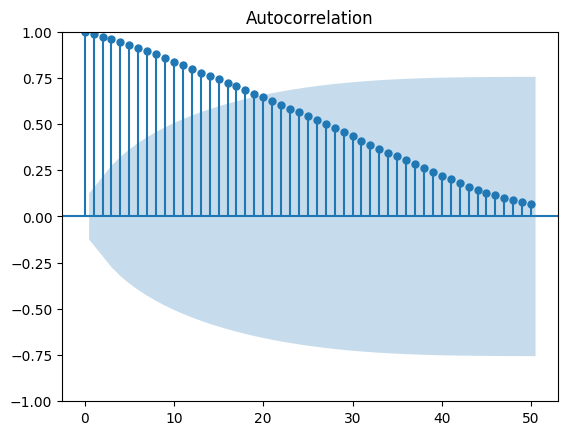

In [50]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df_limpo, lags=50)
plt.show()

O intervalo de confiança por padrão é 95%, mostrado como essa marca azul. Observações que estão para fora da marca são consideradas estatisticamente correlacionadas.

A interpretação do ACF geralmente envolve identificar padrões significativos de autocorrelação nos lags. Se a autocorrelação em um determinado lag for significativa (por exemplo, ultrapassando linhas pontilhadas que indicam intervalos de confiança), isso sugere uma possível sazonalidade ou padrão repetitivo nos dados.

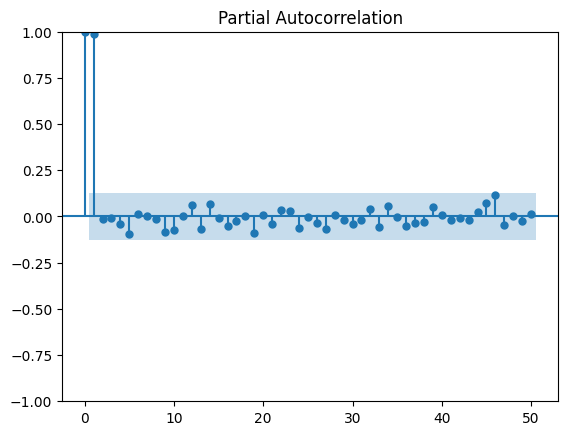

In [51]:
sm.graphics.tsa.plot_pacf(df_limpo, lags=50)
plt.show()

Fazendo a análise de correlação parcial direta, os lags não contribuem significativamente para a estrutura da autocorrelação parcial após considerar os efeitos dos lags intermediários (veja os lags na área em azul).

A interpretação do PACF geralmente está relacionada à identificação do atraso específico que contribui para a autocorrelação em um determinado ponto. Ou seja, **ajuda a identificar a ordem de defasagem apropriada para um modelo AR (autoregressivo)**.


## Analisando a média móvel com o desvio padrão



In [56]:
rolmean = df_limpo.rolling(window=12).mean() #média móvel em 12 meses (dando a média móvel no nível anual).
rolstd = df_limpo.rolling(window=12).std()   #Desvio padrão em 12 meses
print(rolmean,rolstd)

                    Close
Date                     
2023-01-23            NaN
2023-01-24            NaN
2023-01-25            NaN
2023-01-26            NaN
2023-01-27            NaN
...                   ...
2024-01-15  132086.000000
2024-01-16  131677.666667
2024-01-17  131205.916667
2024-01-18  130757.500000
2024-01-19  130324.333333

[247 rows x 1 columns]                   Close
Date                   
2023-01-23          NaN
2023-01-24          NaN
2023-01-25          NaN
2023-01-26          NaN
2023-01-27          NaN
...                 ...
2024-01-15  1213.195780
2024-01-16  1262.790945
2024-01-17  1297.878231
2024-01-18  1624.375656
2024-01-19  1711.056788

[247 rows x 1 columns]


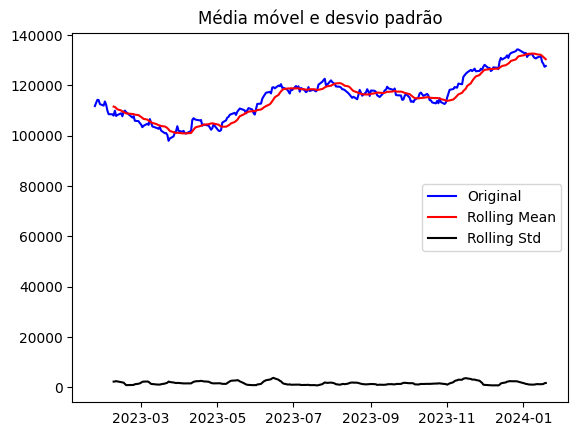

In [57]:
#Plotando a média móvel
orig = plt.plot(df_limpo, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Média móvel e desvio padrão')
plt.show(block=False)

No gráfico acima, vemos que a própria média móvel tem um componente de tendência, embora o desvio padrão contínuo seja bastante constante com o tempo. Para que nossa série temporal seja estacionária, precisamos garantir que ambas as estatísticas tenham uma tendência.

O desvio padrão é uma medida de dispersão que quantifica o quanto os valores em um conjunto de dados tendem a se afastar da média. Neste caso, podemos observar que os dados variam muito!

Mas, como podemos comprovar realmente que esta série temporal não é estacionária?


# Verificar estacionariedade da série temporal 📈

# Teste de Dickey-Fuller ✍


Para aumentar ainda mais nossa hipótese de que a série temporal não é estacionária, vamos realizar o teste ADCF:

O teste de ***Dickey-Fuller Aumentado (ADF)*** permite saber sem **há presença significativa de tendência nas séries temporais** das variáveis por meio de um teste de hipótese.



**Estatística ADF:**

- H0 (Hipótese Nula): A série temporal não é estacionária.

- H1 (Hipótese Alternativa): A série temporal é estacionária.


**Interpretação:** Se a estatística ADF for menor que os valores críticos, podemos rejeitar a hipótese nula e considerar a série temporal estacionária. Quanto mais negativa a estatística, mais forte é a evidência contra a hipótese nula.

**Valor p (p-value):**

**Interpretação:** Um valor p menor que um determinado nível de significância (**por exemplo, 0.05**) fornece evidência contra a hipótese nula, sugerindo que a série temporal é estacionária.

**Estacionariedade**
Para trabalhar com séries temporais em alguns modelos, precisamos que ela seja estacionária. Essa característica além de ser necessária para algum modelos, facilita a projeção dos dados. Portanto é considerado uma série estacionaria aquela série que em certos períodos possui a mesma média.

A tendência e a sazonalidade afetarão o valor da série temporal em momentos diferentes. Por outro lado, para a estacionaridade, não importa quando você a observa, ela deve parecer a mesma em qualquer momento. Em geral, uma série temporal estacionária não terá padrões previsíveis no longo prazo.

In [59]:
from statsmodels.tsa.stattools import adfuller

# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df_limpo['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -0.640596733363518
p-value: 0.8615424938762681
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -0.640596733363518
Valor-p: 0.8615424938762681
Valores Críticos:
   1%: -3.457215237265747
   5%: -2.873361841566324
   10%: -2.5730700760129555


Para que uma série temporal seja estacionária, seu teste ADCF:

- valor p alto (de acordo com a hipótese nula) (valor p no máximo pode ser 1)
- Os valores críticos em intervalos de confiança de 1%,5%,10% devem ser o mais próximo possível das Estatísticas de Teste.

Portanto, podemos dizer com segurança que nossa Série Temporal no momento **não** é estacionária.


# Transformando a série e estacionária

### 1º teste 🔍: subtrair os dados transformados pelo log pela média móvel.


**Objetivo:** Estabilizar a variância em uma série temporal, especialmente quando a amplitude dos dados varia ao longo do tempo.



---



Vamos utilizar o **logarítmo** para realizar a transformação dos dados. Nosso objetivo é **remover o componente de tendência**. Portanto, curvas mais planas (ou seja: paralelas ao eixo x) para séries temporais e médias contínuas após obter o log diriam que nossa transformação de dados fez um bom trabalho.

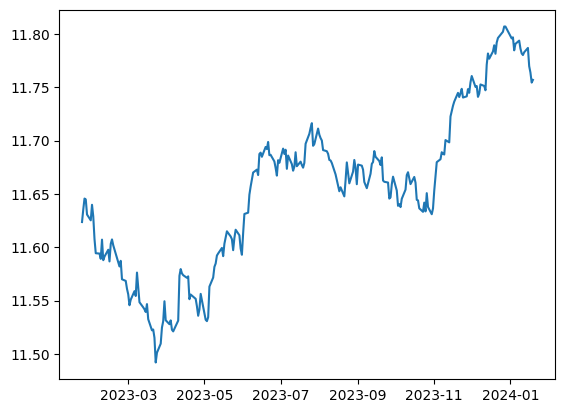

In [60]:
#Estimating trend
indexedDataset_logScale = np.log(df_limpo) #Transformação logarítma
plt.plot(indexedDataset_logScale)

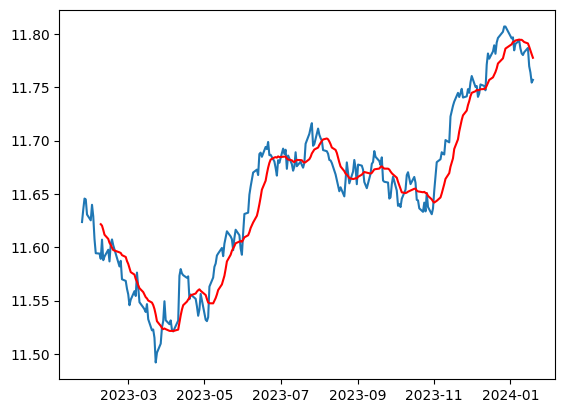

In [61]:
# Calculando a média móvel
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

Vamos subtrair os dados transformados pelo log menos a média móvel para remover o componente de tendência de ambos. (Aqui buscamos isolar os padrões sazonais ou os componentes residuais.)



In [62]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Close
Date,
2023-02-07,-0.032496
2023-02-08,-0.013105
2023-02-09,-0.028432
2023-02-10,-0.020501
2023-02-13,-0.010151
2023-02-14,-0.017449
2023-02-15,0.000819
2023-02-16,0.007746
2023-02-17,0.004510


In [63]:
# Função para testar a estacionariedade da série transformada

def test_stationarity(timeseries):

    #Determinar estatísticas contínuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Close'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


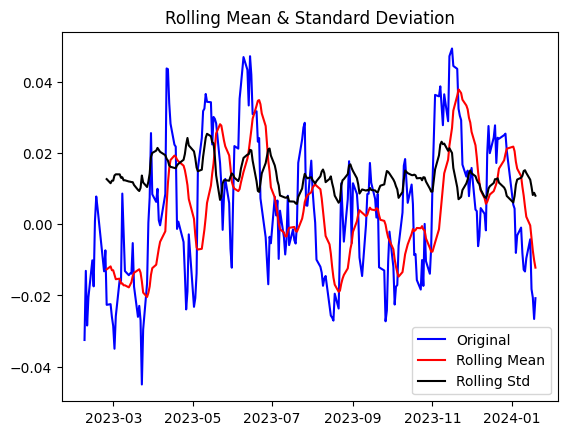

Results of Dickey Fuller Test:
Test Statistic                  -4.009688
p-value                          0.001361
#Lags Used                       1.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


In [64]:
test_stationarity(datasetLogScaleMinusMovingAverage)

### 2º teste : Decaimento exponencial.



---



**Objetivo:** Remover a tendência de uma série temporal. A ideia básica é aplicar uma média exponencial ponderada aos dados, atribuindo mais peso às observações mais recentes e menos peso às observações mais antigas.


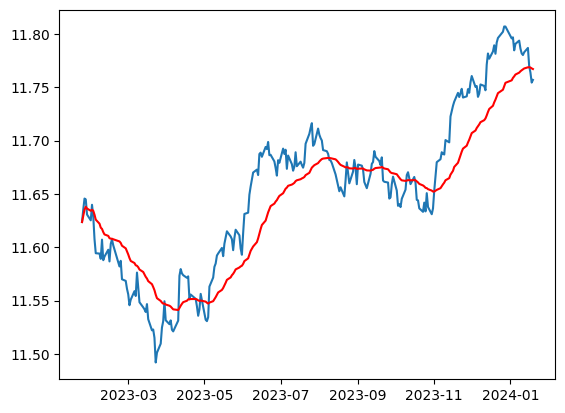

In [65]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

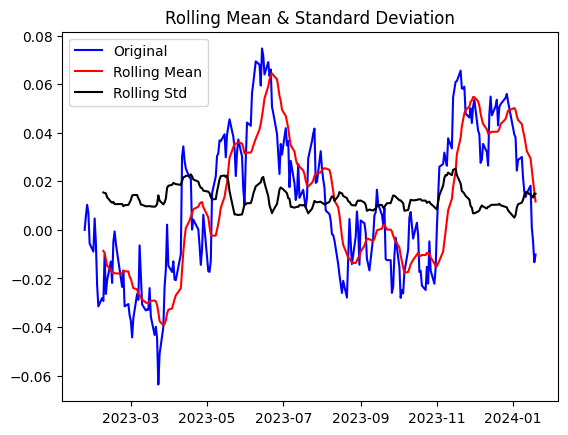

Results of Dickey Fuller Test:
Test Statistic                  -2.590473
p-value                          0.094982
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


In [66]:
# Subtraindo o dataset em escala logarítma pelo decaimento exponencial
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

### 3º teste : Diferenciação



---



**Objetivo:** Remover a tendência e tornar a série mais estacionária.

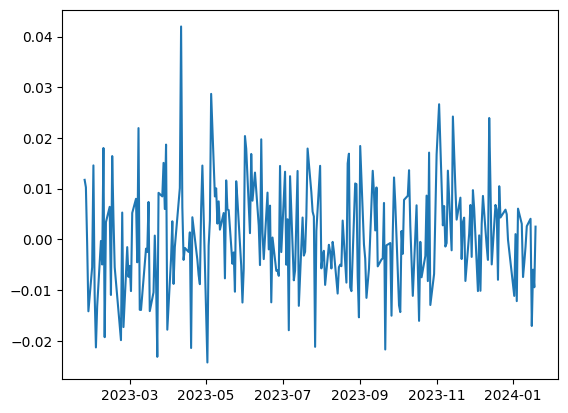

In [67]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift() #diferença entre o valor anterior e o atual
plt.plot(datasetLogDiffShifting)

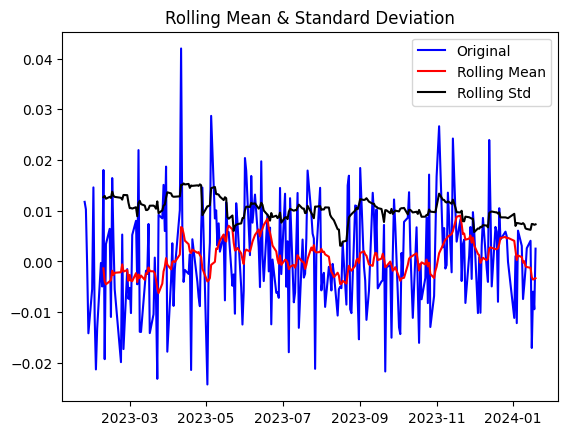

Results of Dickey Fuller Test:
Test Statistic                -1.507682e+01
p-value                        8.566929e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


In [68]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

# Teste de correlação parcial

Como definimos numa primeira tentativa o parâmetro **P (lags: valores auto correlacionados)** e o parâmetro **Q (tamanho de uma janela)** do ARIMA?

Vamos fazer isso com os **gráfico de ACF** (para ‘q’) e o **gráfico de PACF** (para ‘p’). Vamos selecionar como teste a base de dados da **diferenciação**.

Vamos encontrar em **qual ponto cada gráfico passa em zero e este ponto será o valor de P e Q inicial** (talvez em alguns casos pequenas alterações nos parâmetros do ARIMA possam melhorar/piorar os resultados, vale a pena alterar um pouco os valores um pouco positivamente e negativamente para olhar o desempenho).

Aplicando os plots ao nosso dataset de entrada (lags é o número de amostras):

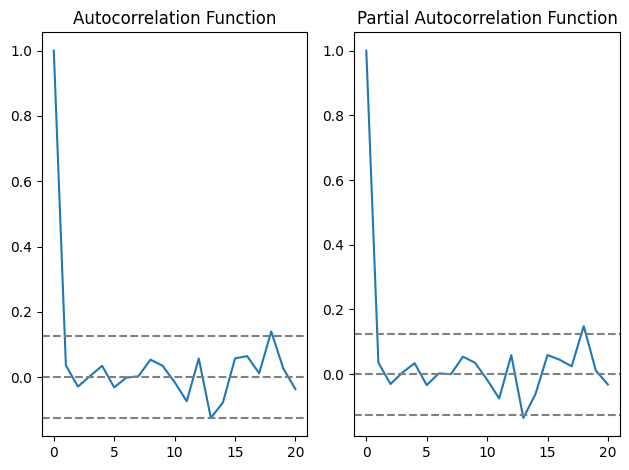

In [69]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

A partir do gráfico ACF, vemos que a curva toca a linha y=0,0 em x=1 (Q = 2);

Do gráfico PACF, vemos que a curva toca a linha y=0,0 em x=1 (P = 2).

ARIMA é AR + I + MA. Antes, vemos um modelo ARIMA, vamos verificar os resultados do modelo AR & MA individual. Observe que esses modelos fornecerão um valor de RSS (Soma dos Quadrados dos Resíduos). Valores RSS mais baixos indicam um modelo melhor.

Com o RSS você está avaliando o quão longe seus pontos estão dos valores verdadeiros. Uma maneira de validar o seu modelo ARIMA é verificar se seu RSS diminui à medida que você faz alterações em seu modelo.

In [ ]:
#! pip install --upgrade statsmodels

Plotting AR model


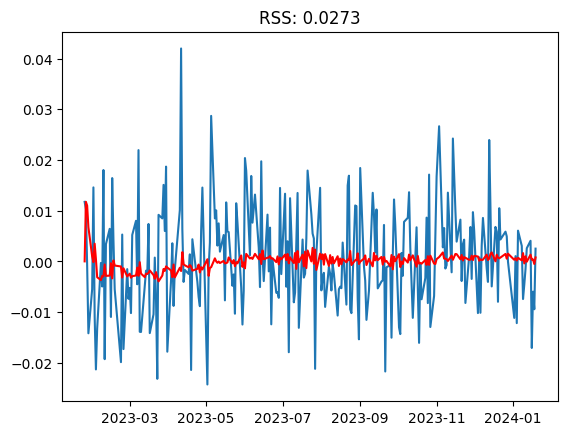

In [74]:
#AR Model
model = ARIMA(datasetLogDiffShifting, order=(2,1,2))#(p,d,q)
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Close'])**2))
print('Plotting AR model')

**Validando o modelo com MAPE  (Mean Absolute Percentage Error)**

 Métrica para valiar a precisão de previsões em séries temporais (perspectiva percentual dos erros). Quanto menor, melhor!
😊

In [75]:
from sklearn.metrics import mean_absolute_error

# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = datasetLogDiffShifting.index

# Inverta a diferenciação
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = indexedDataset_logScale['Close'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(datasetLogDiffShifting['Close'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 1157.88%


Um MAPE tão alto geralmente indica que as previsões do modelo estão muito distantes dos valores reais. 😞

# Testando o modelo com prophet 🔮

O prophet é uma ferramenta de previsão para séries temporais desenvolvida pelo Facebook. O Prophet é especialmente projetado para lidar com **séries temporais que possuem padrões sazonais fortes e vários pontos de mudança**.

O Prophet é um vidente, capaz de entender e prever tendências, sazonalidades e feriados.🔮 Mágico né?

O Prophet se destaca em sua capacidade de lidar com dados faltantes, tendências que mudam ao longo do tempo e até mesmo feriados! Ele foi projetado para ser flexível e intuitivo, tornando a previsão de séries temporais uma tarefa mais simples, mesmo para aqueles que não são especialistas em estatística.


In [78]:
# Especifique o símbolo da Bola e o intervalo de datas desejado
symbol = '^BVSP'
start_date = '2023-01-01'
end_date = '2024-01-22'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)
df[['ds','y']] = df[['Date','Close']]
df.head()



[*********************100%%**********************]  1 of 1 completed


,Date,Close,ds,y
0,2023-01-02,106376.0,2023-01-02,106376.0
1,2023-01-03,104166.0,2023-01-03,104166.0
2,2023-01-04,105334.0,2023-01-04,105334.0
3,2023-01-05,107518.0,2023-01-05,107518.0
4,2023-01-06,108836.0,2023-01-06,108836.0


## Seprando os dados em treino e teste

In [79]:
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (210, 4)
testing data size : (52, 4)


In [80]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=20, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnj7yxqa0/grv0_0_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnj7yxqa0/6goel21d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56649', 'data', 'file=/tmp/tmpnj7yxqa0/grv0_0_b.json', 'init=/tmp/tmpnj7yxqa0/6goel21d.json', 'output', 'file=/tmp/tmpnj7yxqa0/prophet_modelp_db8xup/prophet_model-20240123003441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:34:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:34:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-02,107030.571957,107676.898231,113587.286968,107030.571957,107030.571957,3570.903709,3570.903709,3570.903709,3465.902428,3465.902428,3465.902428,105.001281,105.001281,105.001281,0.0,0.0,0.0,110601.475666
1,2023-01-03,107006.919522,107866.444779,113589.590865,107006.919522,107006.919522,3757.741828,3757.741828,3757.741828,3465.902428,3465.902428,3465.902428,291.839400,291.839400,291.839400,0.0,0.0,0.0,110764.661350
2,2023-01-04,106983.267088,107741.949278,113530.662919,106983.267088,106983.267088,3638.995312,3638.995312,3638.995312,3465.902428,3465.902428,3465.902428,173.092884,173.092884,173.092884,0.0,0.0,0.0,110622.262400
3,2023-01-05,106959.614653,107388.144570,113568.094500,106959.614653,106959.614653,3539.743907,3539.743907,3539.743907,3465.902428,3465.902428,3465.902428,73.841479,73.841479,73.841479,0.0,0.0,0.0,110499.358560
4,2023-01-06,106935.962219,107809.798147,113656.279894,106935.962219,106935.962219,3688.603736,3688.603736,3688.603736,3465.902428,3465.902428,3465.902428,222.701308,222.701308,222.701308,0.0,0.0,0.0,110624.565954


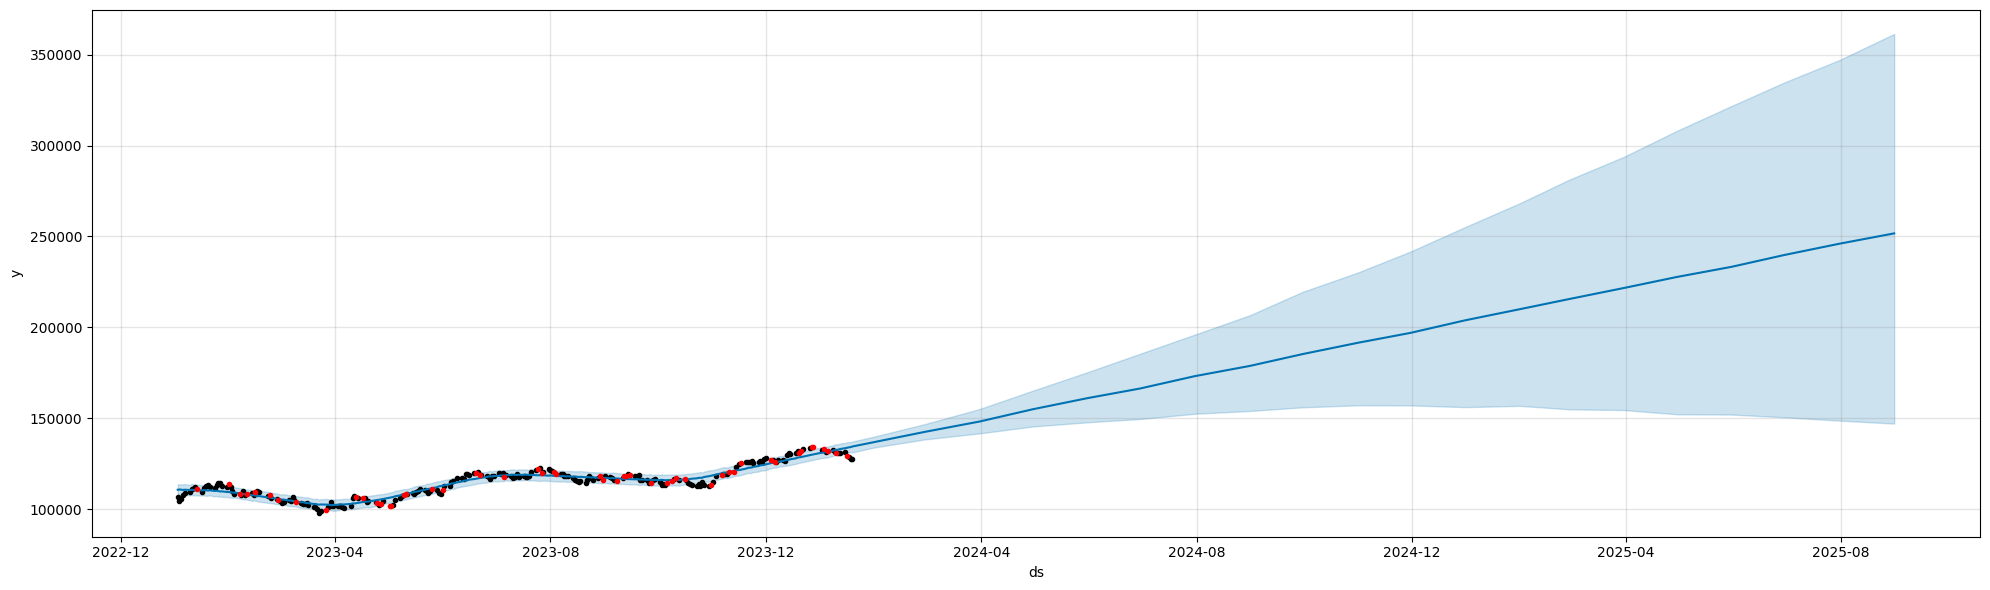

In [81]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

Uma das características mais úteis do Prophet é sua capacidade de decompor automaticamente uma série temporal em seus componentes. Isso inclui a tendência geral, sazonalidade anual e efeitos de feriados (se fornecidos)

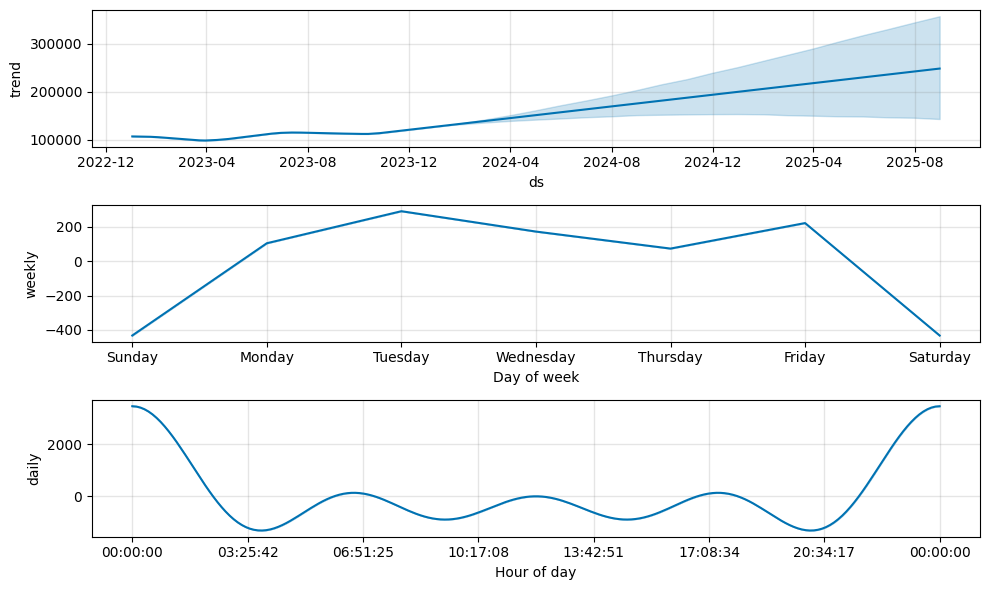

In [82]:
modelo.plot_components(previsao, figsize=(10,6));

In [83]:

# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 1.57%


## Cross validation


In [91]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='100 days', period='40 days', horizon = '65 days')


INFO:prophet:Making 6 forecasts with cutoffs between 2023-04-29 00:00:00 and 2023-11-15 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnj7yxqa0/nlbw4_xh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnj7yxqa0/7kpu69pn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35796', 'data', 'file=/tmp/tmpnj7yxqa0/nlbw4_xh.json', 'init=/tmp/tmpnj7yxqa0/7kpu69pn.json', 'output', 'file=/tmp/tmpnj7yxqa0/prophet_modelk8yibmwi/prophet_model-20240123003756.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:37:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:37:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnj7yxqa0/nwe1fofr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnj7yxqa0/z0n7zu5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

In [92]:
df_cv.head()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-05-04,105763.584529,103854.278731,107678.271364,102174.0,2023-04-29
1,2023-05-05,105637.237618,103752.511705,107559.157589,105148.0,2023-04-29
2,2023-05-08,105692.969072,103806.730501,107488.843886,106042.0,2023-04-29
3,2023-05-09,106236.495343,104393.899936,108089.506766,107114.0,2023-04-29
4,2023-05-12,106391.493730,104401.198157,108307.843193,108464.0,2023-04-29


In [93]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,2.881499e+07,5367.959209,3857.233236,0.031842,0.021257,0.032731,0.450000
1,8 days,3.140205e+07,5603.753166,4031.516472,0.033132,0.020610,0.034120,0.450000
2,9 days,3.712115e+07,6092.712776,4515.210711,0.036977,0.028192,0.038164,0.400000
3,10 days,3.434182e+07,5860.189732,4092.296479,0.033432,0.015029,0.034533,0.487500
4,11 days,3.189604e+07,5647.658288,3952.790260,0.032260,0.015727,0.033310,0.512500
5,12 days,3.460810e+07,5882.864650,4095.125647,0.033271,0.013067,0.034422,0.525000
6,13 days,3.292817e+07,5738.307621,3904.126087,0.031758,0.013006,0.032851,0.516667
7,14 days,3.292189e+07,5737.759655,3812.946139,0.030990,0.012023,0.032074,0.575000
8,15 days,3.364370e+07,5800.319318,3757.003213,0.030470,0.013006,0.031573,0.583333
9,16 days,4.120473e+07,6419.091029,4329.377831,0.035028,0.016437,0.036378,0.500000


https://facebook.github.io/prophet/docs/diagnostics.html

### Aplicando o algoritmo LSTM para prever 🤖

Vamos agora utilizar uma Rede LSTM (Long Short-Term Memory) para prever o comportamento da empresa.

LSTM é um tipo especial de **rede neural recorrente**, pois são capazes de aprender conexões de longo prazo. Dessa maneira, elas têm um incrível poder de predição e funcionam muito bem em uma variada gama de problemas que envolvem capturas de padrões de longo prazo em séries temporais, textos longos, gravações de áudios e muito mais. O principal trabalho dessa rede neural se torna entender como uma memória deve influenciar a outra, ou seja, como a rede decide quais partes da memória de curto prazo devem ser lembradas e como a memória de longo prazo deve afetar o entendimento atual do texto.



In [95]:
df = df_Bolsa
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)

df.head()

,Date,Close
0,2023-01-23,111709.0
1,2023-01-24,113028.0
2,2023-01-25,114195.0
3,2023-01-26,114109.0
4,2023-01-27,112502.0


In [96]:
close_data = df['Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

### Normalizando os dados

In [97]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

### Separação da base de treino e teste:

In [98]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

197
50


In [99]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [100]:
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
10/10 [==============================] - 2s 13ms/step - loss: 0.1333 - mean_squared_error: 0.1333
Epoch 2/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0360 - mean_squared_error: 0.0360
Epoch 3/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 4/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 5/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 6/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 7/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 8/20
10/10 [==============================] - 0s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 9/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 10/20
10/10 [=====

In [101]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

40/40 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Erro Quadrático Médio 0.0034898011945188046


In [102]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')


40/40 [==============================] - 0s 5ms/step
MAPE: 1.8982


In [103]:
#O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.05907453930856173


O RMSE fornece uma métrica de erro na mesma unidade que a variável alvo (nesse caso, o preço de fechamento). Portanto significa que, em média, as previsões do modelo estão desviando em torno de 0.024 unidades da variável de destino. Quanto menor o RMSE, melhor é o desempenho do modelo em termos de previsões de regressão. Esse modelo ficou top né?

In [105]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da Bolsa",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

40/40 [==============================] - 0s 7ms/step


Será que podemos melhorar esses resultados?

# Validando com suavização da série temporal

In [106]:
df = df_Bolsa
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.head()

,Date,Close
0,2023-01-23,111709.0
1,2023-01-24,113028.0
2,2023-01-25,114195.0
3,2023-01-26,114109.0
4,2023-01-27,112502.0


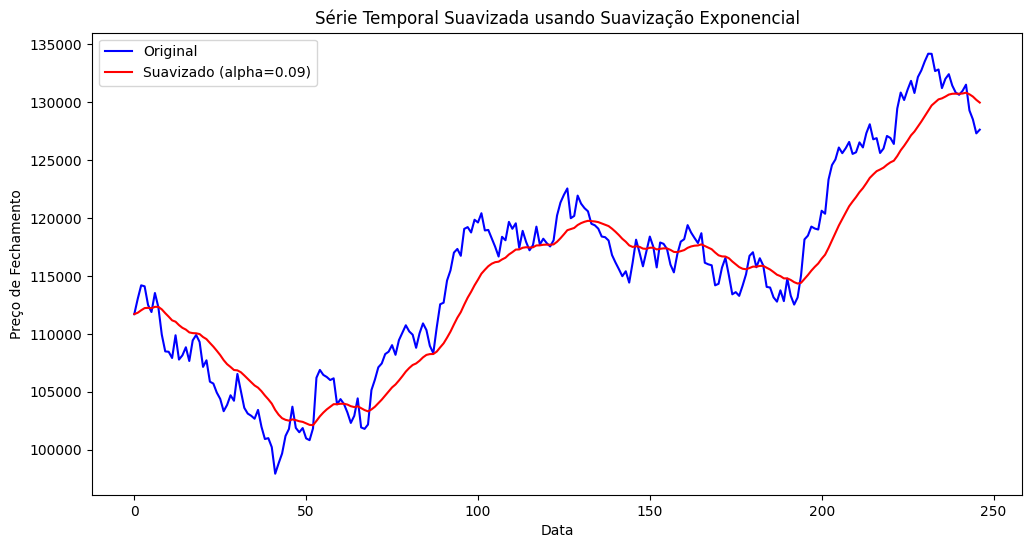

In [107]:
# Suazivando a série temporal
# Aplicando suavização exponencial
alpha = 0.09   # Fator de suavização
# O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
# Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

df['Smoothed_Close'] = df['Close'].ewm(alpha=alpha, adjust=False).mean()

# Visualizando os resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original', color='blue')
plt.plot(df.index, df['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [108]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df['Smoothed_Close'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -0.9725800879432787
p-value: 0.7631332721850008
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -0.9725800879432787
Valor-p: 0.7631332721850008
Valores Críticos:
   1%: -3.4573260719088132
   5%: -2.873410402808354
   10%: -2.573095980841316


In [109]:
df.drop(columns=['Close'], inplace=True)
df.head()

,Date,Smoothed_Close
0,2023-01-23,111709.000000
1,2023-01-24,111827.710000
2,2023-01-25,112040.766100
3,2023-01-26,112226.907151
4,2023-01-27,112251.665507


In [110]:
close_data = df['Smoothed_Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [111]:
close_data

array([[3.34062906e-01],
       [3.38197795e-01],
       [3.45618933e-01],
       [3.52102570e-01],
       [3.52964950e-01],
       [3.51824907e-01],
       [3.55941189e-01],
       [3.55834254e-01],
       [3.48313579e-01],
       [3.36939884e-01],
       [3.26483235e-01],
       [3.15287396e-01],
       [3.11249791e-01],
       [3.00995486e-01],
       [2.92814564e-01],
       [2.87551792e-01],
       [2.79041583e-01],
       [2.76886760e-01],
       [2.76377314e-01],
       [2.74026528e-01],
       [2.65144216e-01],
       [2.58841916e-01],
       [2.47316724e-01],
       [2.36320951e-01],
       [2.23872737e-01],
       [2.10830090e-01],
       [1.95641458e-01],
       [1.83512631e-01],
       [1.75089876e-01],
       [1.65945513e-01],
       [1.64871953e-01],
       [1.59289896e-01],
       [1.49655262e-01],
       [1.39329716e-01],
       [1.29340981e-01],
       [1.19445570e-01],
       [1.12823245e-01],
       [1.02241968e-01],
       [8.92931829e-02],
       [7.77449032e-02],


In [112]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

197
50


In [113]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 5

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [114]:
np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 100
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
10/10 [==============================] - 2s 7ms/step - loss: 0.1553 - mean_squared_error: 0.1553
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0956 - mean_squared_error: 0.0956
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0533 - mean_squared_error: 0.0533
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0248 - mean_squared_error: 0.0248
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 8/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 9/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 10/100
10/10 

In [115]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f"MAPE: {mape:.2f}%")


45/45 [==============================] - 0s 3ms/step
MAPE: 0.86%


In [116]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio:", mse[0])

45/45 [==============================] - 0s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Erro Quadrático Médio: 0.0012045684270560741


In [117]:
# O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.03470689307696778


Plotando os resultados! 📈

In [119]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da Bolsa",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

45/45 [==============================] - 1s 9ms/step


# Realizando o Forecasting  🔮

Agora chegou o momento de prever o futuro!

Vamos criar uma função para prever o futuro, vamos passar como parametro um  número X de dias e a ideia dessa função é excutar o predict do modelo para nos retornar os dias futuros.

In [120]:
close_data = close_data.reshape((-1))


# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas

def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 15 #definição dos próximos dias
forecast = predict(num_prediction, model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 40ms/step


In [121]:
trace1 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast Bolsa",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

# Organizando os dados em um dataframe

In [122]:
df = pd.DataFrame(df)
df_past = df[['Date','Smoothed_Close']]
df_past.rename(columns={'Smoothed_Close': 'Actual'}, inplace=True)         #criando nome das colunas
df_past['Date'] = pd.to_datetime(df_past['Date'])                          #configurando para datatime
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past.head(3)

,Date,Actual,Forecast
0,2023-01-23,111709.0000,NaN
1,2023-01-24,111827.7100,NaN
2,2023-01-25,112040.7661,NaN


In [123]:
# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast)

In [124]:
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan
df_future.head()

,Date,Actual,Forecast
0,2024-01-19,NaN,129977.077608
1,2024-01-20,NaN,131279.949979
2,2024-01-21,NaN,131460.855784
3,2024-01-22,NaN,131609.132218
4,2024-01-23,NaN,131850.779169


In [125]:
# Concatenando os DataFrames usando concat
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('Date')
results.head()

,Actual,Forecast
Date,,
2023-01-23,111709.000000,NaN
2023-01-24,111827.710000,NaN
2023-01-25,112040.766100,NaN
2023-01-26,112226.907151,NaN
2023-01-27,112251.665507,NaN


In [126]:
results.tail()

,Actual,Forecast
Date,,
2024-01-30,NaN,135330.995628
2024-01-31,NaN,135973.788086
2024-02-01,NaN,136689.046909
2024-02-02,NaN,137492.600797
2024-02-03,NaN,138386.287591


In [129]:
results2023 =  results.loc['2024-01-22':]

In [131]:
plot_data = [
    go.Scatter(
        x=results2023.index,
        y=results2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results2023.index,
        y=results2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast Bolsa'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

import plotly as ply
ply.offline.plot(fig)

'temp-plot.html'